# Transfer Learning with YAMNet for environmental sound classification

## Import TensorFlow and other libraries

In [1]:
!pip3 install -q tensorflow_io

     |████████████████████████████████| 25.4MB 149kB/s 


In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

## Loading YAMNet for TensorFlow Hub

In [3]:
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_model = hub.load(yamnet_model_handle)

In [4]:
testing_wav_file_name = tf.keras.utils.get_file("miaow_16k.wav",
                                                "https://storage.googleapis.com/audioset/miaow_16k.wav",
                                                cache_dir="./",
                                                cache_subdir="test_data")

print(testing_wav_file_name)

221184/215546 [==============================] - 0s 0us/step
./test_data/miaow_16k.wav


In [5]:
@tf.function
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents,
                                         desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

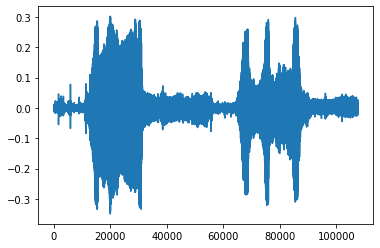

In [7]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

display.Audio(testing_wav_data, rate=16000)

## Loading the class mapping

In [8]:
class_map_path = yamnet_model.class_map_path().numpy().decode("utf-8")
class_names = list(pd.read_csv(class_map_path)["display_name"])

for name in class_names[:20]:
  print(name)
print("...")

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


## Run inference

In [9]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print(f"The main sound is: {infered_class}")
print(f"The embeddings shape: {embeddings.shape}")

The main sound is: Animal
The embeddings shape: (13, 1024)


## ESC-50 dataset

In [11]:
_ = tf.keras.utils.get_file("esc-50.zip",
                        "https://github.com/karoldvl/ESC-50/archive/master.zip",
                        cache_dir="./",
                        cache_subdir="datasets",
                        extract=True)

645701632/Unknown - 43s 0us/step

## Explore the data

In [12]:
esc50_csv = "./datasets/ESC-50-master/meta/esc50.csv"
base_data_path = "./datasets/ESC-50-master/audio/"

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Filter the data

In [14]:
my_classes = ["dog", "cat"]
map_class_to_id = {"dog": 0, "cat": 1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd["category"].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd["filename"].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


## Load the audio files and retrieve embeddings

In [16]:
filenames = filtered_pd["filename"]
targets = filtered_pd["target"]
folds = filtered_pd["fold"]

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [17]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
def extract_embedding(wav_data, label, fold):
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
          tf.repeat(label, num_embeddings),
          tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## Split the data

In [19]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

In [22]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name="input_embedding"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(len(my_classes))
], name="my_model")

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [23]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=["accuracy"])

callbacks = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                             patience=3,
                                             restore_best_weights=True)

In [24]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callbacks)

Epoch 1/20
15/15 [==============================] - 10s 46ms/step - loss: 1.7705 - accuracy: 0.7845 - val_loss: 0.2628 - val_accuracy: 0.8687
Epoch 2/20
15/15 [==============================] - 0s 32ms/step - loss: 0.4400 - accuracy: 0.8682 - val_loss: 0.3455 - val_accuracy: 0.8813
Epoch 3/20
15/15 [==============================] - 1s 38ms/step - loss: 0.2953 - accuracy: 0.9185 - val_loss: 0.5833 - val_accuracy: 0.8750
Epoch 4/20
15/15 [==============================] - 1s 38ms/step - loss: 0.3382 - accuracy: 0.9056 - val_loss: 0.2024 - val_accuracy: 0.9250
Epoch 5/20
15/15 [==============================] - 1s 38ms/step - loss: 0.1719 - accuracy: 0.9057 - val_loss: 0.2160 - val_accuracy: 0.9125
Epoch 6/20
15/15 [==============================] - 1s 37ms/step - loss: 0.1989 - accuracy: 0.8871 - val_loss: 0.2102 - val_accuracy: 0.9125
Epoch 7/20
15/15 [==============================] - 1s 39ms/step - loss: 0.1662 - accuracy: 0.8990 - val_loss: 0.2421 - val_accuracy: 0.8750
Epoch 8/20
1

In [25]:
loss, accuracy = my_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

5/5 [==============================] - 0s 7ms/step - loss: 0.5498 - accuracy: 0.8062
Loss: 0.5497773885726929
Accuracy: 0.8062499761581421


## Test your model

In [26]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

infered_class = my_classes[result.mean(axis=0).argmax()]
print(f"The main sound is: {infered_class}")

The main sound is: cat


## Save a model that can directly take a wav file as input

In [27]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis
  
  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [29]:
saved_model_path = "./dogs_and_cats_yamnet"

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name="audio")
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name="yamnet")
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name="classifier")(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


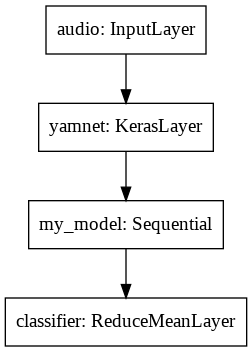

In [30]:
tf.keras.utils.plot_model(serving_model)

In [31]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [32]:
serving_results = reloaded_model.signatures["serving_default"](testing_wav_data)
cat_or_dog = my_classes[tf.argmax(serving_results["classifier"])]
print(f"The main sound is: {cat_or_dog}")

The main sound is: cat


## Some more testing

./datasets/ESC-50-master/audio/5-169983-A-5.wav
Waveform values: [-5.5530812e-08  1.5579258e-07 -1.3647924e-07 ... -1.0891285e-02
 -1.0113415e-02 -9.4338730e-03]


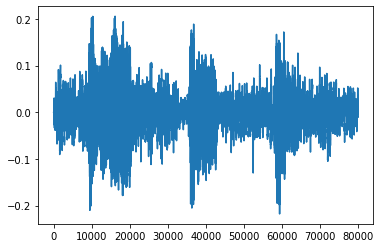

In [35]:
test_pd = filtered_pd.loc[filtered_pd["fold"] == 5]
row = test_pd.sample(1)
filename = row["filename"].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f"Waveform values: {waveform}")
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [36]:
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]
top_score = class_scores[top_class]
print(f"[YAMNet] The main sound is: {infered_class} ({top_score})")

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_infered_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f"[Your model] The main sound is: {your_infered_class} ({your_top_score})")

[YAMNet] The main sound is: Animal (0.5838781595230103)
[Your model] The main sound is: cat (0.9928188920021057)
